<a href="https://colab.research.google.com/github/MINGofHope/nlp/blob/master/seq_to_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose
A note for translate German to English using sequence to sequence model.
Check [Origin](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) for details. 

Here is the model architecture.
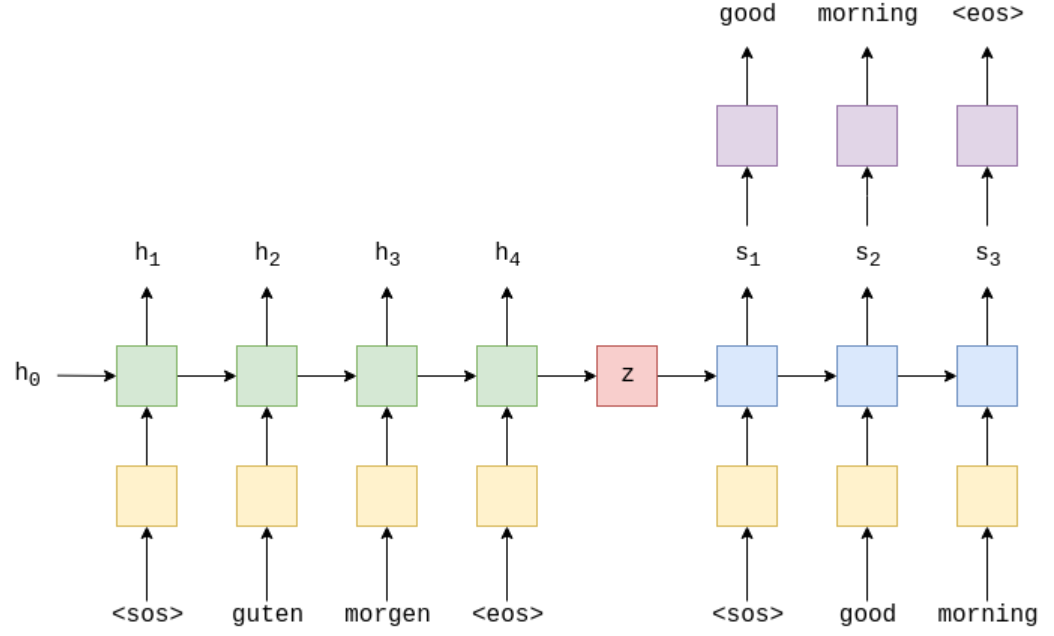

# Preparing Data

In [1]:
!pip install torchtext==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import packages

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy  # for tokenization

import random
import math
import time

In [3]:
# Set seed for deterministic results
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Download models
!python -m spacy download en_core_web_sm  # English model
!python -m spacy download de_core_news_sm  # German model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 24.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [5]:
 # Load Models
 spacy_de = spacy.load('de_core_news_sm')
 spacy_en = spacy.load('en_core_web_sm')

In [6]:
# Tokenize Text
def tokenize_de(text):
  '''Tokenizes German text from a string into a list of strings and reverse it'''
  return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)][::-1]

In [7]:
# Field - Defines a datatype together with instructions for converting to Tensor. Ex. <sos> ... <eos>
# Geman as source; English as target
# starting and end with specific token, and convert them into lowercase, with spacy tokenizer
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)  
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [8]:
# Download Multi30k dataset, and split them into train, valid, and test data
# exts specifies which language to use, and fields aim to fields 
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [9]:
print(f'Number of training examples:{len(train_data)}')
print(f'Number of validation examples:{len(valid_data)}')
print(f'Number of test examples:{len(test_data)}')

Number of training examples:29000
Number of validation examples:1014
Number of test examples:1000


In [10]:
print(vars(train_data.examples[0])) # print de-en token pairs, make sure that german tokens are reversed

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['.', 'bushes', 'many', 'near', 'outside', 'are', 'males', 'white', ',', 'young', 'two']}


In [11]:
# Get tokens that occur more than 2 times
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
print(SRC.vocab)

In [12]:
print(f'Unique tokens in source(de) vocabulary: {len(SRC.vocab)}')
print(f'Unique tokens in target(en) vocabulary: {len(TRG.vocab)}')

Unique tokens in source(de) vocabulary: 7853
Unique tokens in target(en) vocabulary: 5893


In [13]:
# Assign GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# Set Hyper-paramters
# Batch enable para-computing and complete one epoch using less time, we use BuckIterator
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), \
                                                                     batch_size = BATCH_SIZE,
                                                                     device=device)

In [15]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    # assign parameters
    # self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, src):
    ''' Return hidden and cell state for each layer'''
    embedded = self.dropout(self.embedding(src))
    outputs, (hidden, cell) = self.rnn(embedded)  # outputs for the final layer

    return hidden, cell

In [16]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, out_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    # assign parameters
    self.output_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(out_dim, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
    self.out = nn.Linear(hid_dim, out_dim)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)  # as we decode just one token each time
    embedded = self.dropout(self.embedding(input))
    outputs, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    prediction = self.out(outputs.squeeze(0))
    return prediction, hidden, cell

In [17]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    assert encoder.hid_dim == decoder.hid_dim, \
    'Hidden dimensions of encoder and decoder must be equal!'
    assert encoder.n_layers == decoder.n_layers, \
    'Hidden n_layers of encoder and decoder must be equal!'
    
  def forward(self, src, trg, teacher_focing_ratio = 0.5):
    batch_size = trg.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    # tensor to store decoder outputs
    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

    # last hidden state of encoder is used as the initial hidden state of the decoder
    hidden, cell = self.encoder(src)

    # first input to the decoder is the <sos> token
    input = trg[0,:]
    for t in range(1, max_len):
      output, hidden, cell = self.decoder(input, hidden, cell)
      outputs[t] = output
    
      # teaching_froceing, yes or no
      teacher_force = random.random() < teacher_focing_ratio

      # sort
      top1 = output.argmax(1)
      input = trg[t] if teacher_force else top1

    return outputs

In [18]:
# Train the Model
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROUPOUT = 0.5
DEC_DROUPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROUPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROUPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [19]:
# Initialize Weight
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [20]:
optimizer = optim.Adam(model.parameters())

In [21]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [22]:
# Train Process
def train(model, iterator, optimizer, criterion, clip):
  model.train()

  epoch_loss = 0
  
  for i, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg
    optimizer.zero_grad()
    output = model(src, trg)
    
    #trg = [trg len, batch size]
    #output = [trg len, batch size, output dim]
    output = output[1:].view(-1, output.shape[-1])
    trg = trg[1:].view(-1)

    #trg = [trg len -1, batch size]
    #output = [trg len - 1, batch size, output dim]  

    loss = criterion(output, trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), clip)
    optimizer.step()
    epoch_loss += loss.item()
  return epoch_loss / len(iterator)

In [23]:
# Evaluation 
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg
      output = model(src, trg, 0)
      output = output[1:].view(-1, output.shape[-1])
      trg = trg[1:].view(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)

In [24]:
# Epoch Time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [25]:
N_EPOCH = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCH):
  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut1-model.pt')
  print(f'Epoch: {epoch+1:02} | Time:{epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss : {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\tVal. Loss: {valid_loss:.3f} | Train PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 01 | Time:0m 36s
	Train Loss : 4.984 | Train PPL: 146.067
	Val. Loss: 4.867 | Train PPL: 129.930
Epoch: 02 | Time:0m 35s
	Train Loss : 4.478 | Train PPL:  88.044
	Val. Loss: 4.919 | Train PPL: 136.914
Epoch: 03 | Time:0m 36s
	Train Loss : 4.255 | Train PPL:  70.460
	Val. Loss: 4.791 | Train PPL: 120.366
Epoch: 04 | Time:0m 35s
	Train Loss : 4.057 | Train PPL:  57.790
	Val. Loss: 4.611 | Train PPL: 100.547
Epoch: 05 | Time:0m 35s
	Train Loss : 3.851 | Train PPL:  47.031
	Val. Loss: 4.446 | Train PPL:  85.320
Epoch: 06 | Time:0m 36s
	Train Loss : 3.640 | Train PPL:  38.079
	Val. Loss: 4.222 | Train PPL:  68.144
Epoch: 07 | Time:0m 35s
	Train Loss : 3.440 | Train PPL:  31.176
	Val. Loss: 4.060 | Train PPL:  57.948
Epoch: 08 | Time:0m 35s
	Train Loss : 3.239 | Train PPL:  25.503
	Val. Loss: 3.903 | Train PPL:  49.547
Epoch: 09 | Time:0m 35s
	Train Loss : 3.069 | Train PPL:  21.526
	Val. Loss: 3.887 | Train PPL:  48.771
Epoch: 10 | Time:0m 35s
	Train Loss : 2.946 | Train PPL:  19.036

In [27]:
# Prediction
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Train PPL: {math.exp(test_loss): 7.3f}')

	Test Loss: 3.996 | Train PPL:  54.388
